In [2]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2 as cv
from Augment import Compose
from IPython.display import clear_output
import os

In [ ]:
test_image = Image.open('me.jpeg')
test_image = ImageOps.grayscale(test_image)
# test_image = np.array(test_image)

test_image = test_image.resize([512,512])
test_image = np.array(test_image)
# wpercent = (512 / test_image.size[0])
# hsize = int((test_image.size[1] * float(wpercent)))
# test_image = test_image.resize((512, hsize), Image.Resampling.LANCZOS)

# plt.imshow(test_image)
print(test_image.size)
plt.imshow(test_image, cmap='gray')


In [2]:
def rotate(matrix, degrees_range, prob):
    # rotation matrix
    if 1-prob < rand.random():
        theta = rand.randint(degrees_range[0], degrees_range[1]) * (np.pi/180) # rotation in radians
        
        rot = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
        
        rotated_matrix = np.zeros_like(matrix)
        h, w = matrix.shape
        cx, cy = w//2, h//2
        for i in range(h):
            for j in range(w):
                x, y = j - (cx), i - (cy)
                rotated_point = np.dot(np.array([x, y]), rot)
                new_y, new_x = rotated_point + np.array([cx, cy])
                new_y, new_x = int(round(new_y)), int(round(new_x))

                if (0<new_y<h-1) and (0<new_x<w-1):
                    rotated_matrix[new_x, new_y] = matrix[i, j]

        return rotated_matrix
    return matrix
        # round to nearest element

In [3]:
def cropResize(matrix, prob):
    if 1-prob < rand.random():
        h, w = matrix.shape

        # randomly choose where to crop, crop window will always be 100x100
        top_left = (rand.randint(0, h-100), rand.randint(0, w-100))
        bottom_right = (top_left[0]+100, top_left[1]+100)
        cropped = matrix[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]

        scale_col, scale_row = h/100, w/100
        cropped_resize = np.zeros((h, w))

        # do nearest neighbor interp
        for row in range(h):
            for column in range(w):
                cropped_resize[row, column] = cropped[int(row/scale_row), int(column/scale_col)]

        return cropped_resize
    else:
        return matrix

In [4]:
def gaussianNoise(matrix, scale=10):
    h, w = matrix.shape

    noise = np.array([rand.gauss(mu=0, sigma=1) for i in range(h*w)])
    noise = noise.reshape((h, w))

    noisy_matrix = matrix + (scale*noise)
    return noisy_matrix

In [5]:
def gaussianBlur(matrix, size, variance):
    lim = size//2
    val = np.linspace(-lim, lim, size)
    kernel = np.zeros((size, size), dtype=float)

    for row in range(size):
        for col in range(size):
            kernel[row, col] = np.exp(- (val[row]**2 + val[col]**2) / (2 * variance**2))
    kernel = kernel / np.sum(kernel)

    padded = np.pad(matrix, (lim, lim), 'edge')
    convolved_matrix = np.zeros_like(matrix)

    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            for krow in range(size):
                for kcol in range(size):
                    convolved_matrix[row, col] += (kernel[krow, kcol] * padded[row+krow, col+kcol])
    
    return np.clip(convolved_matrix, 0, 255)


In [6]:
def adjustBrightness(matrix):
    scalaing_factor = rand.randrange(50, 150)/100
    return matrix*scalaing_factor

In [7]:
def adjustsharpness(matrix):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])

    padded = np.pad(matrix, (1, 1), 'edge')
    convolved_matrix = np.zeros_like(matrix, dtype=float)

    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            for krow in range(3):
                for kcol in range(3):
                    convolved_matrix[row, col] += (kernel[krow, kcol] * padded[row+krow, col+kcol])

    return np.clip(convolved_matrix, 0, 255)


In [8]:
def perspectiveShift(matrix):
    rows, cols = matrix.shape
    row_shift, col_shift = int(rows*0.2), int(cols*0.2)

    if rand.random() > 0.5:
        # src = [[top left], [top right], [bottom left], [bottom right]]
        src = np.array([[0, 0], [0, cols-1], [rows-1, 0], [rows-1, cols-1]], dtype=np.float32)
        # dst pinch top left and bottom left in. Leave right side unchanged
        dst = np.array([[row_shift, col_shift], [1, cols-2], [(rows-1)-row_shift, col_shift], [rows-2, cols-2]], dtype=np.float32)
    else:
        src = np.array([[0, 0], [0, cols-1], [rows-1, 0], [rows-1, cols-1]], dtype=np.float32)
        # dst pinch top left and bottom left in. Leave right side unchanged
        dst = np.array([[1, 1], [1, (cols-1)-col_shift], [rows-2, 1], [(rows-1)-row_shift, (cols-1)-col_shift]], dtype=np.float32)
    
    eq_mat = []
    for (sx, sy), (dx, dy) in zip(src, dst):
        eq_mat.append([-sx, -sy, -1, 0, 0, 0, sx*dx, sy*dx, dx])
        eq_mat.append([0, 0, 0, -sx, -sy, -1, sx*dy, sy*dy, dy])

    eq_mat = np.array(eq_mat, dtype=np.float32)

    b = eq_mat[:, -1]
    A = eq_mat[:, :-1]
    M = np.linalg.solve(A, b)
    M = np.append(M, -1) 
    M = np.reshape(M, (3,3)) * -1

    # shifted_image = cv.warpPerspective(matrix, M, dsize=(rows, cols))
    shifted_image = np.zeros_like(matrix, dtype=float)
    
    
    for row in range(rows):
        for col in range(cols):
            start = np.array([col, row, 1])
            end = M @ start.T
            end = end/end[2]
            final_col, final_row = int(end[0]), int(end[1])

            if 0 <= final_row < rows and 0 <= final_col < cols:
                shifted_image[row, col] = matrix[final_row, final_col]

    return shifted_image, M



In [9]:
def cropPaste(matrix):
    rows, cols = matrix.shape
    crop_rows, crop_cols = int(rows*0.2), int(cols*0.2)

    start_row, end_row = rand.randint(0, (rows-crop_rows-1)), rand.randint(0, (rows-crop_rows-1))
    start_col, end_col = rand.randint(0, (cols-crop_cols-1)), rand.randint(0, (cols-crop_cols-1))

    cropped = np.copy(matrix)
    cropped[end_row:(end_row+crop_rows), end_col:(end_col+crop_cols)] = cropped[start_row:(start_row+crop_rows), start_col:(start_col+crop_cols)]
    cropped[start_row:(start_row+crop_rows), start_col:(start_col+crop_cols)] = 0

    return cropped


In [9]:
# Making the test set
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

transforms = T.Compose(
        [T.ToTensor()]
)
dataset = datasets.MNIST(root='mnist_data', train=False, transform=transforms, download=False)

loader = DataLoader(dataset, batch_size=1, shuffle=False)
label_list = []
for i, (sample, label) in enumerate(loader):
    if i > 1000 and i <= 2000:
        plt.imsave(f'project data/test set/{i:04}.png', sample[0][0], cmap='gray')
        label_list.append(label.item())
    else:
        continue
    
np_list = np.array(label_list)
np.save('project data/test_labels', np_list)

In [28]:
# making my different datasets

# geometric1 -- flip vert, flip horizontal, rotate
    # test_func_list = {'flipHorizontal':[0.5], 'flipVertical':[0.5], 'rotate':[(-45, 45), 1.0]}
# geometric2 -- perspective, cropResize, cropPaste
    # test_func_list = {'cropPaste':[None], 'perspectiveShift':[None], 'cropResize':[0.5]}
# Pixel1 -- gaussianNoise, adjustBrightness, gaussianBlur
    # test_func_list = {'gaussianNoise':[None], 'adjustBrightness':[None], 'gaussianBlur':[9, 1]}
# Pixel2 -- adjustSharpness, adjustBrightness, gaussianNoise
    # test_func_list = {'adjustSharpness':[None], 'adjustBrightness':[None], 'gaussianNoise':[None]}
# Mixed1 -- flip vert, flip horizontal, gaussianNoise, cropResize
    # test_func_list = {'flipVertical':[0.5], 'flipHorizontal':[0.5], 'gaussianNoise':[None], 'cropResize':[0.5]}
# Mixed2 -- rotate, perspective, adjustSharpness, adjustBrigthness
    # test_func_list = {'rotate':[(-45, 45), 1.0], 'perspectiveShift':[None], 'adjustSharpness':[None], 'adjustBrightness':[None]}
# Mixed3 -- gaussianBlur, rotate, cropResize
    # test_func_list = {'gaussianBlur':[9, 1], 'rotate':[(-45, 45), 1.0], 'cropResize':[0.5]}

test_func_list = {'gaussianBlur':[9, 1], 'rotate':[(-45, 45), 1.0], 'cropResize':[0.5]}
for idx in range(1000):
    
    src = f'project data/MNIST raw/{idx:04d}.png'
    img = Image.open(src)
    img_matrix = np.array(img)

    compose = Compose(img_matrix, **test_func_list)
    transformed = compose.result

    # transformed_img = Image.fromarray(transformed)
    # transformed_img.save(f'project data/geometric2/{idx:04d}.png')
    plt.imsave(f'project data/mixed3/{idx:04d}.png', transformed, cmap='gray')

    clear_output()
    print(f'{idx+1}/1000')




1000/1000


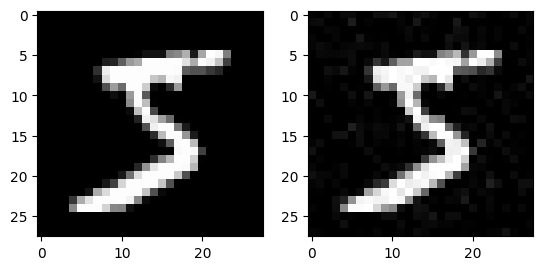

In [22]:
# debugging for datasets
test_func_list = {'gaussianNoise':[None], 'adjustBrightness':[None]}
src = f'project data/MNIST raw/0000.png'
img = Image.open(src)
img_matrix = np.array(img)

compose = Compose(img_matrix, **test_func_list)
new = compose.result
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_matrix, cmap='gray')
ax[1].imshow(new, cmap='gray')
plt.show()


In [ ]:
# Making a simple model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        self.linear1 = nn.Linear((28*28*32), 128)
        self.linear2 = nn.Linear(128, 10) 

      
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.flatten(start_dim=1)

        x = self.linear1(x)
        x = F.relu(x)

        logits = self.linear2(x)
        return logits


In [44]:
# Setting up the training, validation, and testing dataloaders
from torch.utils.data import Dataset, DataLoader

class TrainTestDataset(Dataset):
    def __init__(self, sample_dir, label_dir, transform=None):

        self.sample_dir = sample_dir
        self.transform = transform

        self.samples = os.listdir(sample_dir)
        self.samples.sort()
        if '.DS_Store' in self.samples:
            self.samples.remove('.DS_Store')

        self.labels = np.load(label_dir)


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample_path = os.path.join(self.sample_dir, self.samples[index])

        sample = np.array(Image.open(sample_path).convert('L'))
        label = self.labels[index]

        if self.transform:
            # only ToTensor will be used
            sample = self.transform(sample)

        return sample, label
    
transforms = T.Compose(
        [T.ToTensor()]
)
dset = TrainTestDataset(sample_dir='project data/pixel2', label_dir='project data/labels.npz.npy', transform=transforms)

train_dset, val_dset = torch.utils.data.random_split(dset, [900, 100])

train_loader = DataLoader(dataset=train_dset, batch_size=16, shuffle=False)
val_loader = DataLoader(dataset=val_dset, batch_size=16, shuffle=False)

testset = TrainTestDataset(sample_dir='project data/test set', label_dir='project data/test_labels.npy', transform=transforms)
test_loader = DataLoader(dataset=testset, batch_size=16, shuffle=False)

In [45]:
# Training the simple model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

loss_list = []
val_list = []
test_list = []
for epoch in range(num_epochs):
    model.train()

    loss_count = 0.0
    for sample, label in train_loader:
        output = model(sample)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        loss_count += loss.item()
    
    loss_list.append(loss_count/len(train_loader))

    model.eval()
    val_loss_count = 0.0
    for sample, label in val_loader:
        with torch.no_grad():
            output = model(sample)
            loss = criterion(output, label)

            val_loss_count += loss.item()

    val_list.append(val_loss_count/len(val_loader))

    clear_output()
    print(f'Epoch {epoch+1} of {num_epochs}')

    test_loss_count = 0.0
    for sample, label in test_loader:
        with torch.no_grad():
            output = model(sample)
            loss = criterion(output, label)

            test_loss_count += loss.item()

    test_list.append(test_loss_count/len(test_loader))
    print(f'Test complete')

print(f'Training Complete')




Epoch 25 of 25
Test complete
Training Complete


In [ ]:
# debugging
transforms = T.Compose(
        [T.ToTensor()]
)
dset = TrainTestDataset(sample_dir='project data/geometric1', label_dir='project data/labels.npz.npy', transform=transforms)

loader = DataLoader(dataset=dset, batch_size=1, shuffle=False)

for sample, label in loader:
    plt.imshow(sample[0][0], cmap='gray')
    print(label.item())
    break

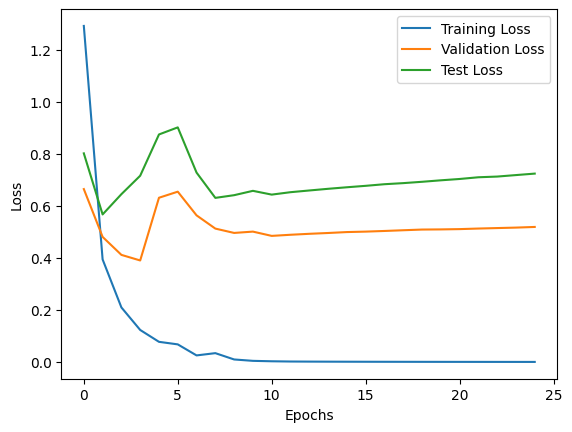

In [46]:
# Making Pretty Graphs
plt.plot(loss_list, label='Training Loss')
plt.plot(val_list, label='Validation Loss')
plt.plot(test_list, label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()